In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_5_normalised_jit_surface_area_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 90, 71)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:71,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((71,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

Add noise to the data (using random sampling from normal distribution)

In [3]:
size_noise = 5
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]

Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
print(model)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 8


Create uniform log prior

In [5]:

# Define the size of the list
size = 8
placeholder_lower_value = 0
placeholder_upper_value = 100
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000



log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_22752/3453305971.py:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.8
1     603     0:10.9
2     1119    0:14.5
3     1692    0:17.7
20    9744    0:42.0
40    16647   1:00.8
60    23427   1:19.7
80    30300   1:38.3
100   37245   1:56.9
120   43974   2:15.4
140   50733   2:33.7
160   57402   2:52.4
180   64050   3:10.4
200   70731   3:28.5
220   77397   3:47.1
240   83913   4:04.6
260   90690   4:22.5
280   97374   4:40.8
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.7285936354919D+02   r2 =  0.1714866015773D-12


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.7901240235647D+02   r2 =  0.7838095046154D-11
300   103968   5:03.9
320   110664   5:22.4
340   117321   5:40.9
360   124083   5:59.1
380   130821   6:17.9
400   137679   6:36.4
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.4854389902469D+02   r2 =  0.5580230796121D-10
420   144561   7:04.4
440   151488   7:23.1
460   158112   7:41.7
480   164901   8:02.5
500   171861   8:21.6
520   178707   8:40.3
540   185325   8:58.1
560   192126   9:17.2
580   198867   9:37.4
600   205371   9:55.6
620   212322  10:17.5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.8136299070283D+02   r2 =  0.5950154799206D-08
640   219117  10:38.9
660   225864  11:00.7
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8123674220116D+02   r2 =  0.1424407991194D-12
680   232689  11:21.5
700   239331  11:39.9
720   246078  12:00.8
740   252990  12:19.4
760   259464  12:37.5
780   266127  12:56.6
800   272820  13:15.1
820   279627  13:33.5
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.7702193006703D+02   r2 =  0.2029236987931D-11
840   286284  13:54.1
860   292920  14:13.6
880   299538  14:32.1
900   306075  14:51.8
920   312687  15:10.4
940   319170  15:28.6
960   326022  15:48.5
980   331263  16:02.6
1000  333406  16:08.6
Halting: Ma

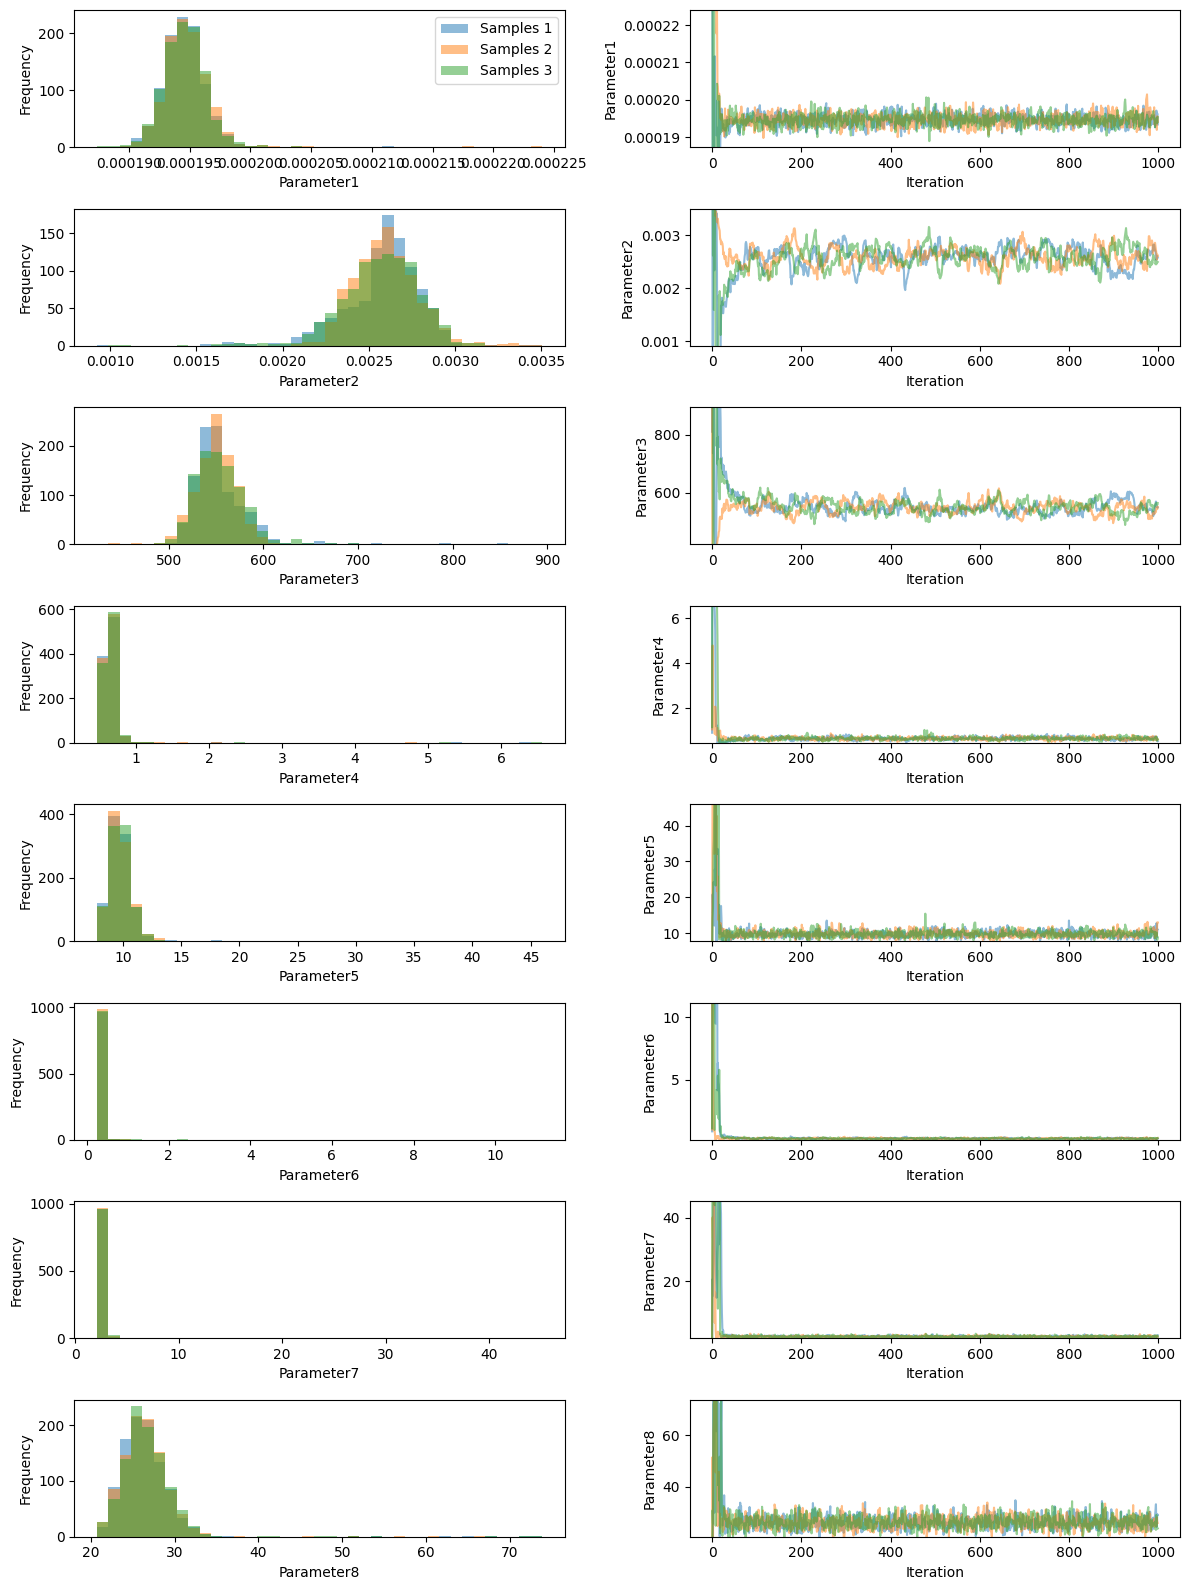

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 8)
[1.95014431e-04 2.75540762e-03 5.30788556e+02 6.56602198e-01
 9.83491496e+00 3.02335452e-01 2.30769943e+00 2.40236719e+01]
[[1.95014431e-04 2.75540762e-03 5.30788556e+02 ... 3.02335452e-01
  2.30769943e+00 2.40236719e+01]
 [1.94416395e-04 2.77012339e-03 5.33600812e+02 ... 2.92919582e-01
  2.59395675e+00 2.89583098e+01]
 [1.97481090e-04 2.76221791e-03 5.30644197e+02 ... 2.88618881e-01
  2.48997558e+00 2.90120183e+01]
 ...
 [1.94387928e-04 2.61545869e-03 5.50924278e+02 ... 2.49097042e-01
  2.72040275e+00 2.47909117e+01]
 [1.96330731e-04 2.58939540e-03 5.51794868e+02 ... 3.45919173e-01
  2.11222665e+00 2.94544481e+01]
 [1.93392334e-04 2.57834804e-03 5.49666299e+02 ... 3.21452123e-01
  2.99029728e+00 2.91491051e+01]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


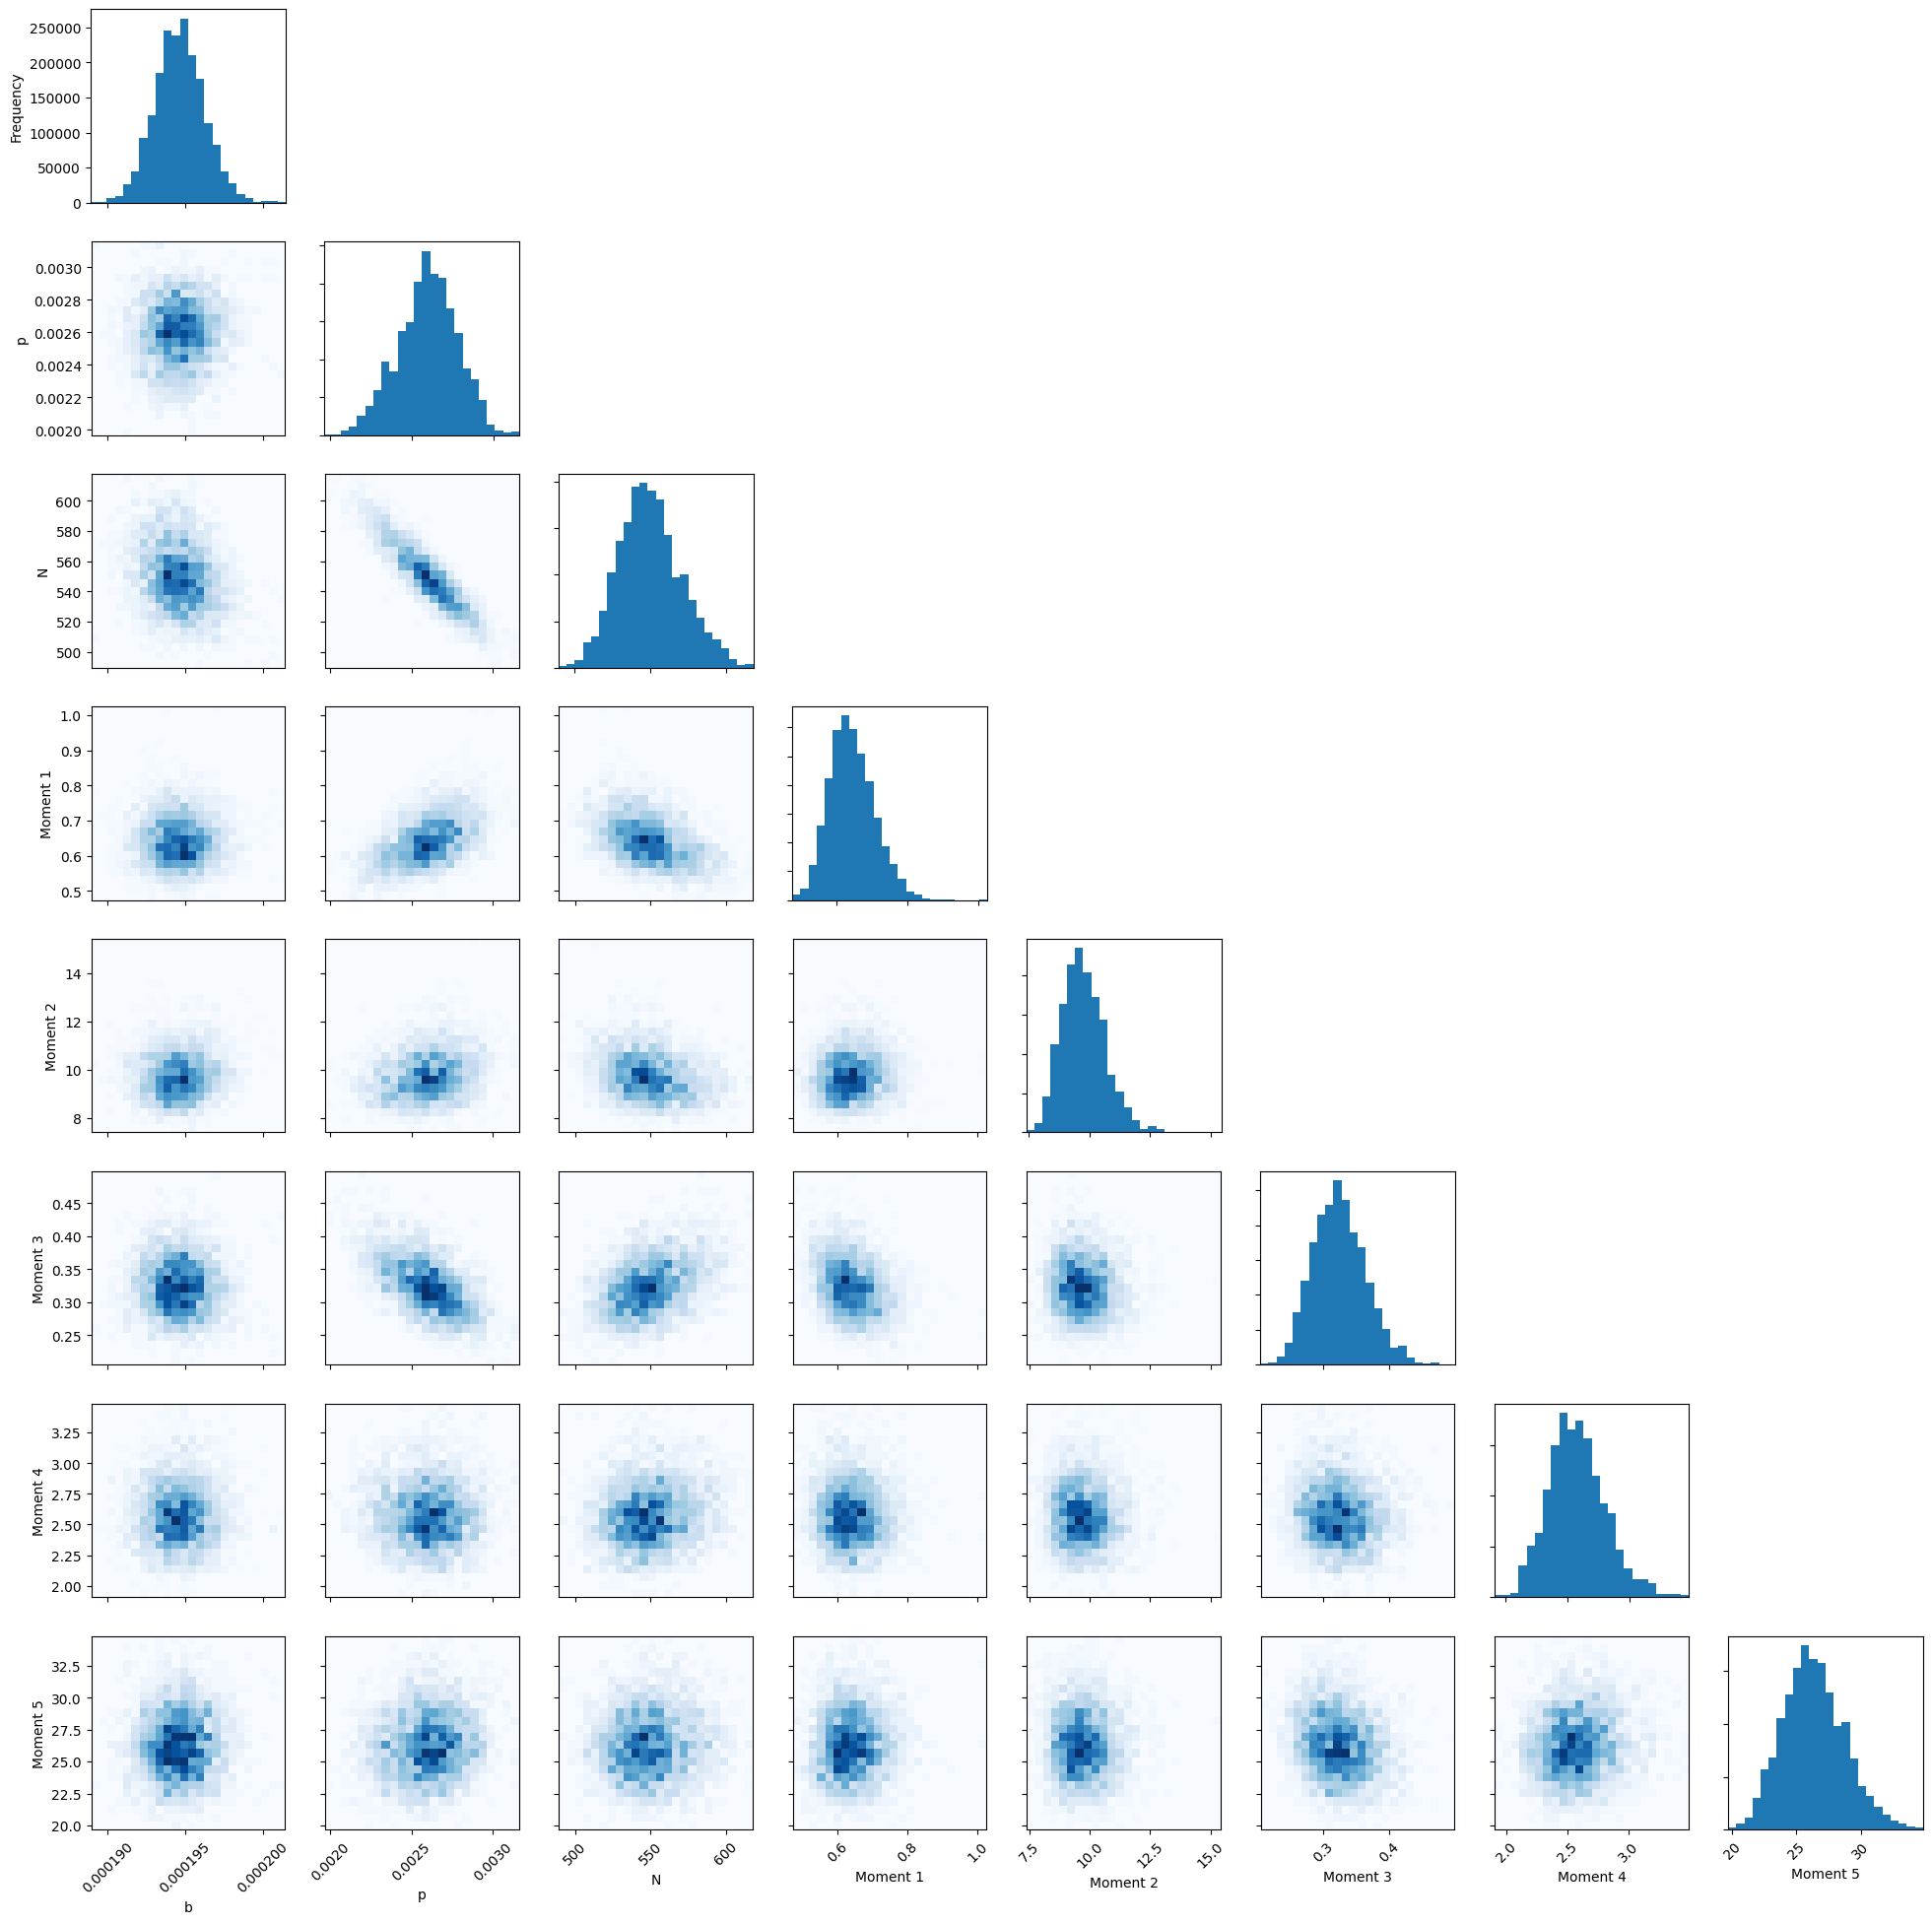

In [11]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

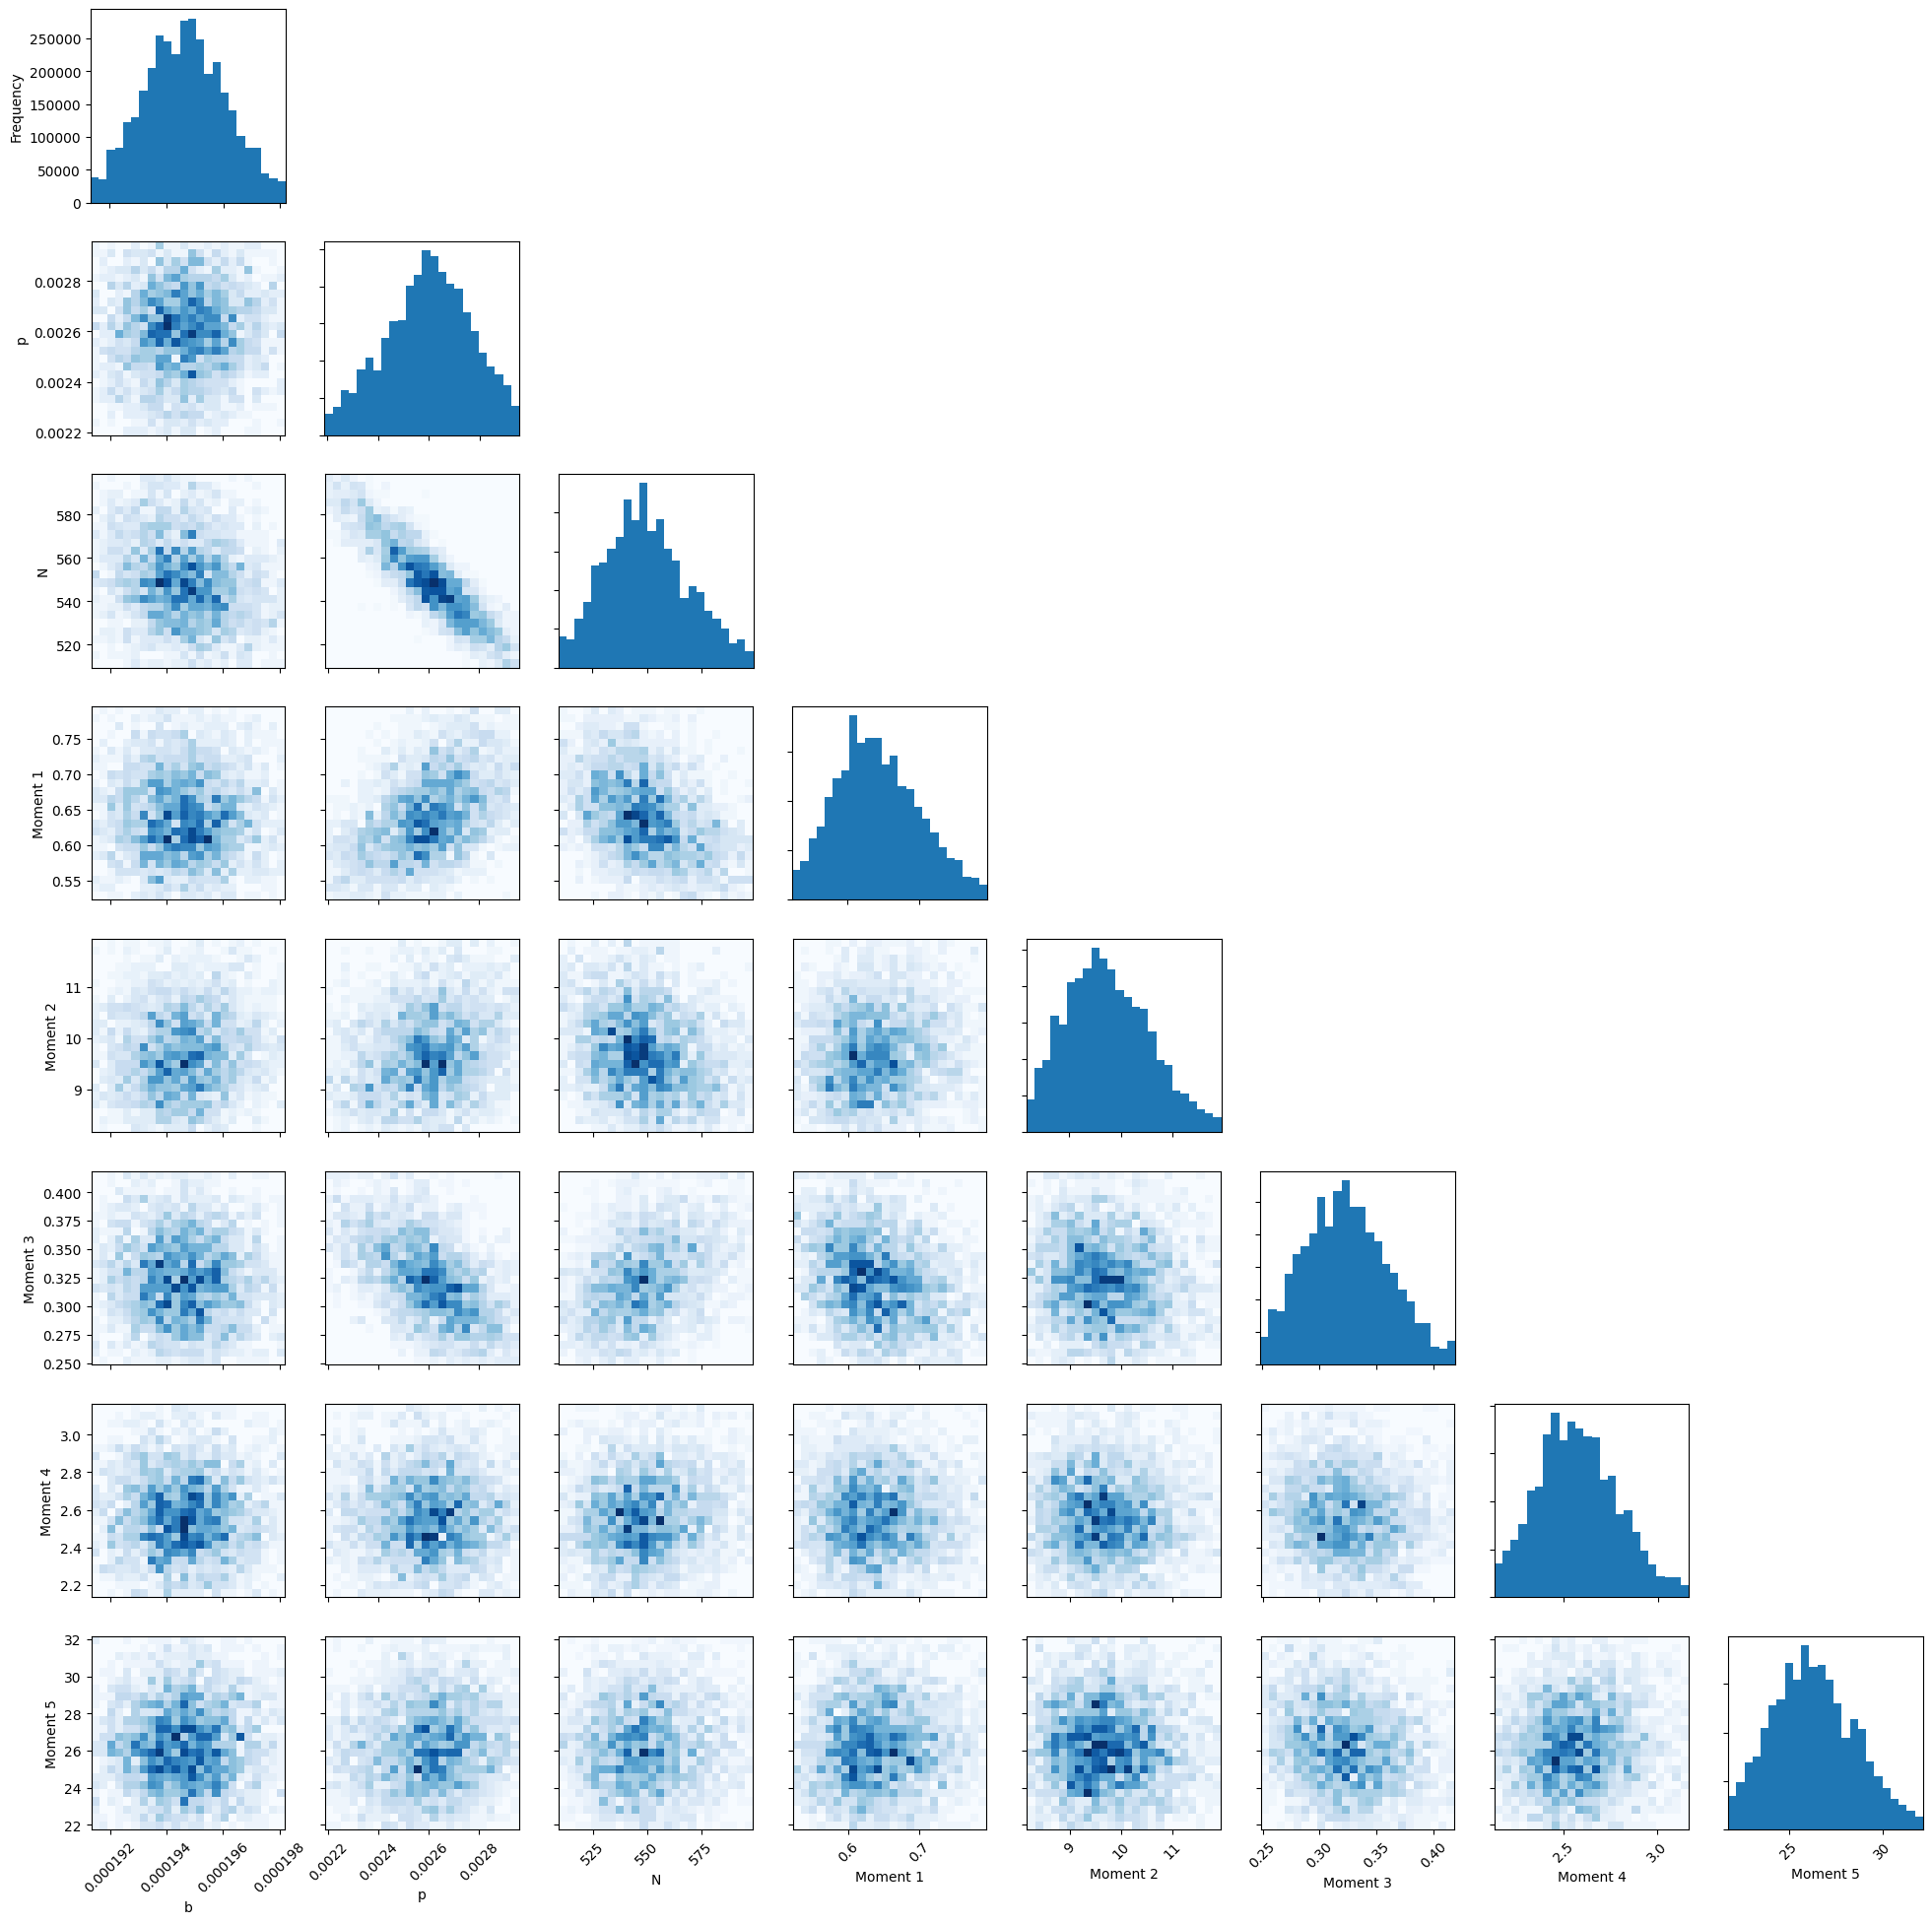

In [12]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

In [13]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.01    362.28  0.37
p         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.02    59.95   0.06
N         548.62  20.00   511.39  535.29  547.52  560.55  593.11   1.02    57.78   0.06
Moment 1  0.65    0.06    0.54    0.60    0.64    0.69    0.78     1.00    209.18  0.22
Moment 2  9.79    0.87    8.32    9.16    9.70    10.36   11.69    1.00    306.32  0.32
Moment 3  0.32    0.04    0.25    0.30    0.32    0.35    0.41     1.00    188.97  0.20
Moment 4  2.58    0.23    2.17    2.42    2.56    2.72    3.07     1.00    457.11  0.47
Moment 5  26.35   2.37    22.10   24.71   26.23   27.83   31.34    1.00    410.63  0.42


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000195  1.54e-06  0.000192  0.000194  0.000195  0.000196  0.000198  1.01    362    0.374
p         0.00261   0.000175  0.00224   0.0025    0.00261   0.00273   0.00293   1.02    60     0.0619
N         549       20        511       535       548       561       593       1.02    57.8   0.0596
Moment 1  0.646     0.063     0.536     0.602     0.639     0.688     0.781     1       209    0.216
Moment 2  9.79      0.874     8.32      9.16      9.7       10.4      11.7      1       306    0.316
Moment 3  0.324     0.0391    0.254     0.297     0.322     0.35      0.407     1       189    0.195
Moment 4  2.58      0.23      2.17      2.42      2.56      2.72      3.07      1       457    0.472
Moment 5  26.3      2.37      22.1      

In [16]:
import math
print(math.log(4))
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)


BIC = len(results.mean())*math.log(4) - 2*log_likelihood(results.mean())

print(BIC)

1.3862943611198906
8
1707.6359479224136
1702.7263028113728


In [17]:
shape_chains = np.shape(AllChains)

DIC_1 = 0
for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    DIC_1 += -2*log_likelihood(thetas)

DIC_1 = DIC_1/shape_chains[0]

DIC_2 = -2*log_likelihood(results.mean())

DIC = 2*DIC_1 - DIC_2

print(DIC)

1707.357341955156


In [ ]:
import scipy as spy

KS_test_array = []
for i in range(71):
    KS_test = spy.stats.kstest(result_interested[i,:], org_values[i,:])
    KS_test_array = np.append(KS_test_array, KS_test.statistic)

plt.plot(KS_test_array)

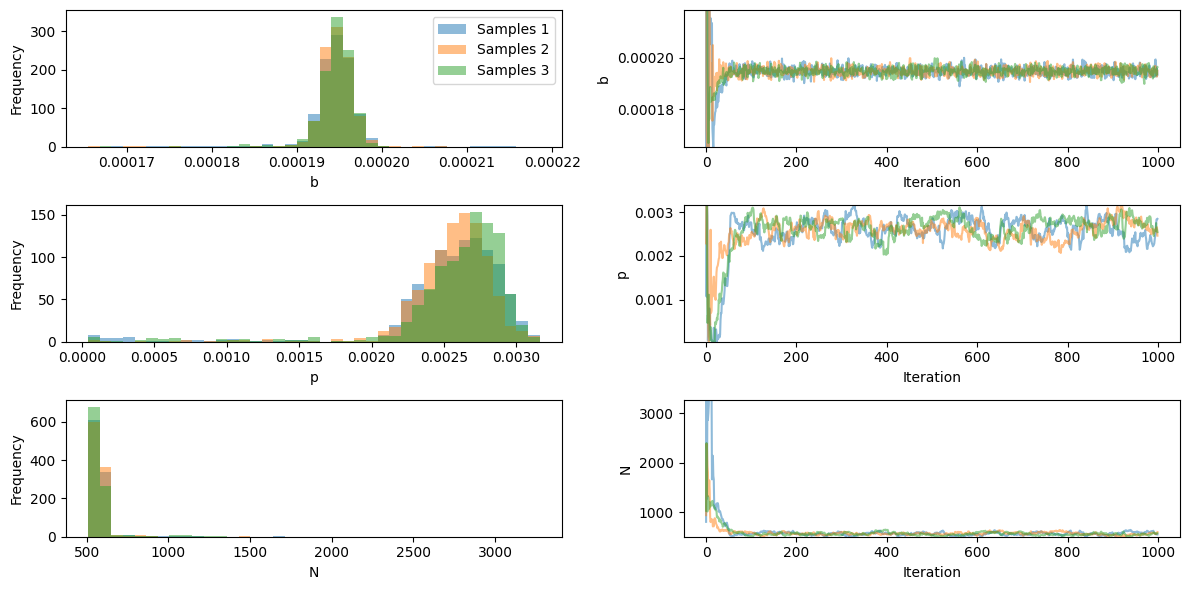

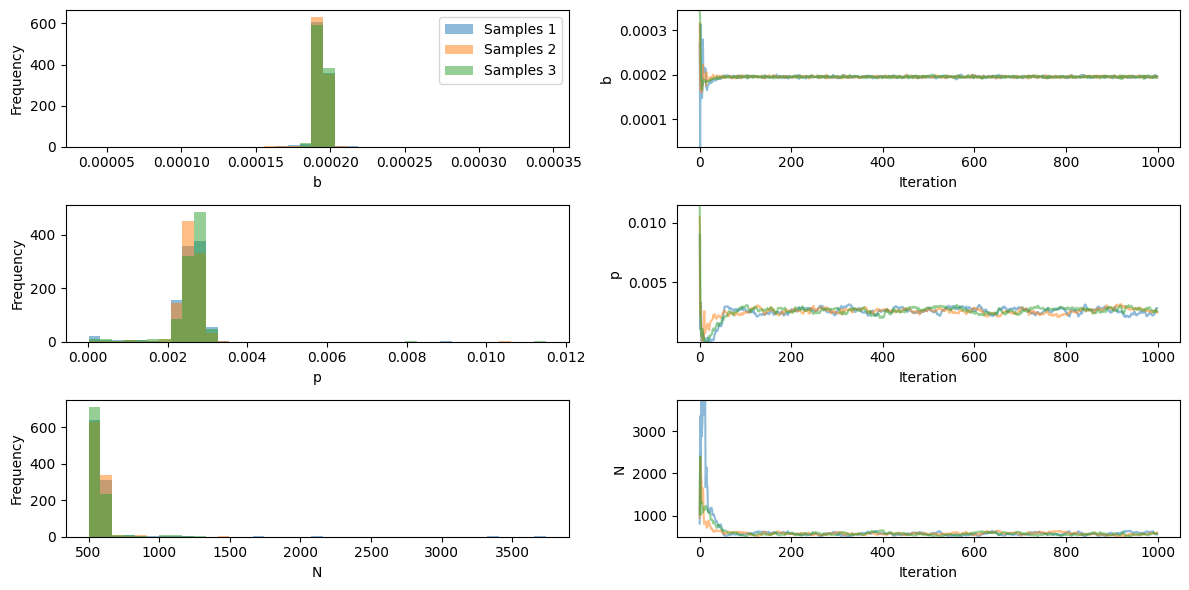

In [ ]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()